In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit
from scipy.special import ellipk #Complete elliptic integral of the first kind

In [25]:
#Read in data
project_directory = os.path.dirname(os.path.abspath("ising_plot.ipynb"))
data_directory = os.path.join(project_directory, "data")
rel_files = os.listdir(data_directory)
abs_files = [os.path.join(data_directory, rel_file) for rel_file in rel_files]
data_files = [file for file in abs_files if not file.find('EM')==-1]
corr_files = [file for file in abs_files if not file.find('SC')==-1]
datas= []
corrs= []
for file in data_files:
    data = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    datas.append(data)
for file in corr_files: 
    corr = pd.read_csv(file, sep=",", skiprows=[0,1,2])
    corrs.append(corr)

In [57]:
T_c_analytic = 2/np.log(1 + np.sqrt(2))  # Analytic critical temperature for the 2D Ising model
ln_T_c_analytic = np.log(T_c_analytic)

def get_E_mean_analytic(T):
    """Calculate the mean energy for the 2D Ising model at temperature T."""
    sinh_T = np.sinh(2/T)
    cosh_T = np.cosh(2/T)
    tanh_T = np.tanh(2/T)
    #kappa = 2*sinh_T/cosh_T**2
    kappa = 2*tanh_T/cosh_T #Numerically more stable?
    ellip_int = ellipk(kappa)
    return -2*tanh_T-(sinh_T**2-1)/(sinh_T*cosh_T)*(2/np.pi*ellip_int-1)

In [ ]:
#Models for fitting
def power_law_fit(T, k, T_c, crit_exp):
    t = (T-T_c)/T_c
    return k * ( t** crit_exp)

#Returns bounds as formatted for curve_fit
#[(L1,U1),(L2,U2),...(LN,UN)] to ([L1,L2,...,LN],[U1,U2,...,UN])
def to_tuple(bounds: list):
  lower = [b[0] for b in bounds]
  upper = [b[1] for b in bounds]
  return (lower,upper)

In [64]:
#Settings for the analysis
selected_trial = 1 #Particular trial to analyze (0-indexed)

#Extract data from pandas DataFrame
data_selected_trial = datas[selected_trial]
corr_selected_trial = corrs[selected_trial]
T, E_mean, E_std, M_mean, M_std, cV_mean, cV_std, Chi_mean, Chi_std = data_selected_trial.T.to_numpy()

#General calculations
N = len(T)
T_min, T_max = T.min(), T.max()
T_analytic = np.linspace(T_min, T_max, 1000)

#Logarithmic scale calculations
ln_T = np.log(T)
ln_T_analytic = np.linspace(np.log(T_min), np.log(T_max), 1000)
def get_ln_std(X_mean, X_std, use_asymetric_error=True):
    if use_asymetric_error: #Asymmetric error handling
        ln_X_std_lower = np.abs(np.log(X_mean-X_std)) 
        ln_X_std_upper = np.abs(np.log(X_mean+X_std))
        ln_X_std = [ln_X_std_lower, ln_X_std_upper] 
    else:
        ln_X_std = X_std / X_mean  # Propagated error (necessarily symmetric)
    return ln_X_std

Text(0.5, 1.0, 'Average Site Energy vs Temperature')

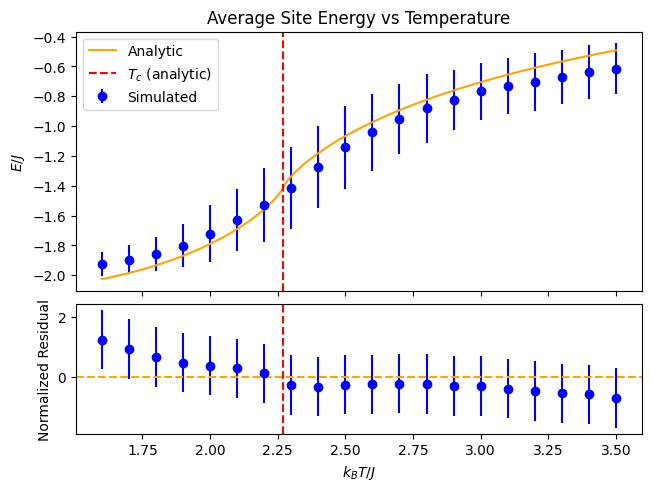

In [65]:
#Average Energy vs Temperature
#Calculate derived quantities
E_mean_res = E_mean - get_E_mean_analytic(T) 
E_std_res = E_std
E_mean_norm_res = E_mean_res / E_std 
E_std_norm_res = E_std_res / E_std #Should be 1 for all T

#Analytic calculations
E_mean_analytic = get_E_mean_analytic(T_analytic) #Note that argument is different in order to produce smooth curve

#Plotting
fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True, height_ratios=[2, 1])
ax, res_ax = axs[0], axs[1]
ax.errorbar(T, E_mean, yerr=E_std, fmt='o', color='blue', label='Simulated')
ax.plot(T_analytic, E_mean_analytic, color='orange', label='Analytic')
res_ax.errorbar(T, E_mean_norm_res, yerr=E_std_norm_res, fmt='o', color='blue', label='Residuals')
res_ax.set_xlabel('$k_BT / J$')
res_ax.set_ylabel('Normalized Residual')
res_ax.axhline(0, color='orange', linestyle='--')
ax.set_ylabel('$E/J$')
ax.axvline(x=T_c_analytic, color='red', linestyle='--', label='$T_c$ (analytic)')
res_ax.axvline(x=T_c_analytic, color='red', linestyle='--', label='$T_c$ (analytic)')
ax.legend()
ax.set_title('Average Site Energy vs Temperature')

In [ ]:
def create_T_plot(X_mean, X_std, X_symbol, X_name, get_X_analytic=None, power_law = True, fit=False, expected_crit_exp=None, from_above=True):
    if expected_crit_exp is None:
        expected_crit_exp = 1.0

    if fit:#Work in progress: need to be careful with signs
        bounds = to_tuple([(-np.inf, np.inf), (0, np.inf), (-np.inf, np.inf)]) #Bounds for k, T_c, crit_exp    
        param_ests = [1, T_c_analytic, expected_crit_exp] 
        if from_above:
            T_filt = T[T >= T_c_analytic]
            X_mean_filt = X_mean[T >= T_c_analytic]
            X_std_filt = X_std[T >= T_c_analytic]                
        else:
            T_filt = T[T <= T_c_analytic]
            X_mean_filt = X_mean[T <= T_c_analytic]
            X_std_filt = X_std[T <= T_c_analytic]        
        
        popt, pcov = curve_fit(power_law_fit, T_filt, X_mean_filt, sigma=X_std_filt, p0=param_ests,bounds=bounds)
        print(popt)
        X_mean_fit = power_law_fit(T,*popt)
        N_filt = len(T_filt) #Number of points used for the fit
        num_constraints = len(popt)
        degrees_of_freedom = N_filt - num_constraints  # Degrees of freedom for the fit

    if get_X_analytic is not None:
        X_mean_analytic = get_X_analytic(T_analytic) #Note that argument is different in order to produce smooth curve 
    else:
        X_mean_analytic = None
    if power_law:
        ln_X_mean = np.log(X_mean)
        ln_X_std = get_ln_std(X_mean, X_std)

        if get_X_analytic is not None:       
            ln_X_mean_analytic = np.log(X_mean_analytic)
        else:
            ln_X_mean_analytic = None
        using = [ln_T,ln_T_analytic,ln_T_c_analytic, ln_X_mean, ln_X_std, ln_X_mean_analytic]
        T_label = '$ln(k_BT / J)$'
        X_label = f'$ln({X_symbol})$'
    else:        
        using = [T,T_analytic,T_c_analytic,X_mean, X_std, X_mean_analytic] #No analytic curve for non-power-law fits
        T_label = '$k_BT / J$'
        X_label = f'${X_symbol}$'
    if get_X_analytic is not None:
        #Residual calculations
        X_mean_res = X_mean - get_X_analytic(T)
        X_std_res = X_std
        X_mean_norm_res = X_mean_res / X_std
        X_std_norm_res = X_std_res / X_std #Should always be 1                   
        #Plotting
        fig, axs = plt.subplots(2,1, constrained_layout=True, sharex=True, height_ratios=[2, 1])
        ax, res_ax = axs[0], axs[1]                
        res_ax.errorbar(using[0], X_mean_norm_res, yerr=X_std_norm_res, fmt='o', color='blue', label='Residuals')
        res_ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')      
        ax.plot(using[1], using[5], color='orange', label='Analytic')               
        res_ax.set_xlabel(T_label)
        res_ax.set_ylabel('Normalized Residual')
        res_ax.axhline(0, color='orange', linestyle='--')      
    else:
        fig, ax = plt.subplots(1,1, constrained_layout=True)
        ax.set_xlabel(T_label)
    ax.errorbar(using[0], using[3], yerr=using[4], fmt='o', color='blue', label='Simulated')
    ax.set_ylabel(X_label)
    ax.axvline(x=using[2], color='red', linestyle='--', label='$T_c$ (analytic)')        
    ax.legend()
    ax.set_title(f'{X_name} vs Temperature')
    plt.show()

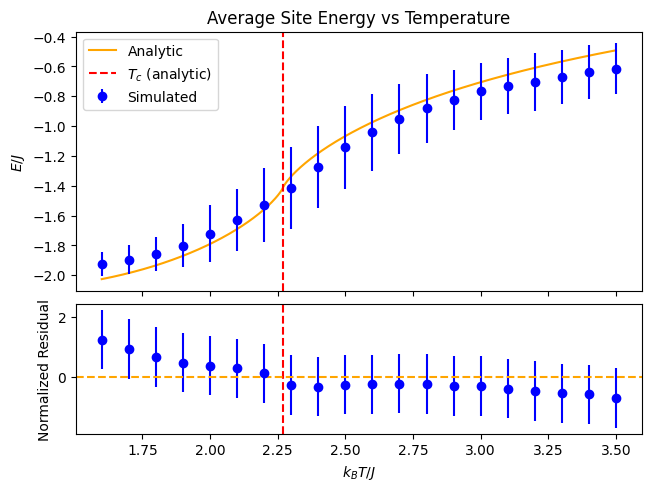

In [106]:
create_T_plot(E_mean, E_std, 'E/J', 'Average Site Energy', get_X_analytic=get_E_mean_analytic)

In [105]:
create_T_plot(cV_mean, cV_std, 'c_V', 'Specific Heat', param_ests=[1, T_c_analytic, 0.5])

ValueError: Initial guess is outside of provided bounds